In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
import librosa 
import librosa.display 
import IPython.display as ipd 

from pydub import AudioSegment 
from pydub.utils import mediainfo 

speech = AudioSegment.from_wav('EmotionSpeech/Train/Sad/03-01-04-01-01-01-01.wav')  #Read audio data from file 
x = speech.get_array_of_samples()  #samples x(t) 
x_sr = speech.frame_rate  #sampling rate f - see slide 24 in week 7 lecture slides 
mfcc = librosa.feature.mfcc( 
y = np.float32(x),  
sr = x_sr, #sampling rate of the signal, which is determined from the signal 
hop_length = int(x_sr * 0.015), #15 ms 
n_mfcc = 12) #number of mfcc features

In [17]:
print(mfcc.shape) 

(12, 256)


Text(0, 0.5, 'Amplitude')

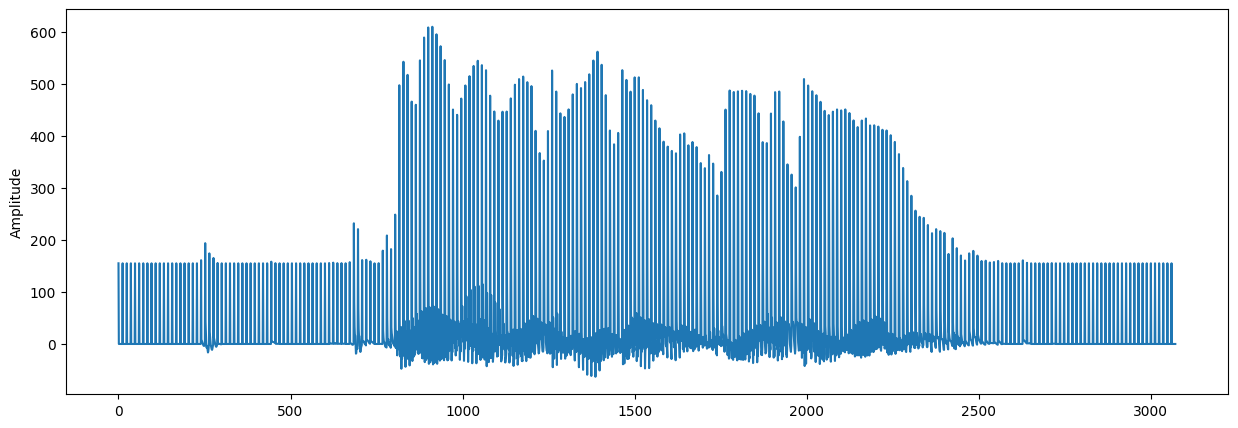

In [18]:
mfcc_flattened = np.reshape(mfcc.T, (mfcc.shape[0] * mfcc.shape[1])) 
plt.figure(figsize = (15, 5)) 
plt.plot(mfcc_flattened) 
plt.ylabel('Amplitude')

In [5]:
import os 
emotions = ['Calm', 'Happy', 'Sad', 'Angry'] 
path = 'EmotionSpeech/' 
training_file_names = [] 
training_emotion_labels = [] 
for i in range(0, len(emotions)): 
    sub_path = path + 'Train/' + emotions[i] + '/' 
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)] 
    sub_emotion_labels = [i] * len(sub_file_names) 
    training_file_names += sub_file_names 
    training_emotion_labels += sub_emotion_labels 

In [6]:
import numpy as np 
import librosa 
from pydub import AudioSegment 
from pydub.utils import mediainfo 
 
def mfcc_extraction(audio_filename, #.wav filename 
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms) 
                    num_mfcc, #number of mfcc features 
                    num_frames #number of frames 
                   ):  
    speech = AudioSegment.from_wav(audio_filename)  #Read audio data from file 
    samples = speech.get_array_of_samples()  #samples x(t) 
    sampling_rate = speech.frame_rate  #sampling rate f 
     
    mfcc = librosa.feature.mfcc( 
        y = np.float32(samples),  
        sr = sampling_rate,  
        hop_length = int(sampling_rate * hop_duration),  
        n_mfcc = num_mfcc) 
        
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32) 
    for i in range(min(num_frames, mfcc.shape[1])): 
        mfcc_truncated[:, i] = mfcc[:, i] 
     
    #output is a 1D vector 
    return np.reshape(mfcc_truncated.T,  
                      mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

In [19]:
# 1. Extract MFCC features from all training audio clips
num_frames = 200
hop_duration = 0.015  # 15 ms
num_mfcc = 12

X_train = []  # List to store MFCC feature vectors
y_train = []  # List to store emotion labels

for fname, label in zip(training_file_names, training_emotion_labels):
    features = mfcc_extraction(fname, hop_duration, num_mfcc, num_frames)
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (128, 2400)
y_train shape: (128,)


In [20]:
# Extract MFCC features from all test audio clips
test_path = 'EmotionSpeech/Test/'
X_test = []
y_test = []
for i, emotion in enumerate(emotions):
    sub_path = os.path.join(test_path, emotion)
    for fname in os.listdir(sub_path):
        full_path = os.path.join(sub_path, fname)
        features = mfcc_extraction(full_path, hop_duration, num_mfcc, num_frames)
        X_test.append(features)
        y_test.append(i)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (128, 2400)
y_test shape: (128,)


In [21]:
# 2. Speech emotion recognition using SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# a. Define SVM model with RBF kernel and C=10.0
svm = SVC(kernel='rbf', C=10.0, random_state=42)

# b. Train SVM model
svm.fit(X_train, y_train)

# c. Predict and evaluate on test set
y_pred = svm.predict(X_test)

# Overall accuracy
overall_acc = accuracy_score(y_test, y_pred)
print('Overall recognition accuracy:', overall_acc)

# Accuracy per emotion
report = classification_report(y_test, y_pred, target_names=emotions, output_dict=True)
for emotion in emotions:
    print(f"Accuracy for {emotion}: {report[emotion]['recall']:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)

Overall recognition accuracy: 0.6640625
Accuracy for Calm: 0.81
Accuracy for Happy: 0.59
Accuracy for Sad: 0.62
Accuracy for Angry: 0.62
Confusion matrix:
[[26  0  6  0]
 [ 2 19  8  3]
 [10  0 20  2]
 [ 3  6  3 20]]


In [22]:
# d. Vary num_mfcc and measure accuracy and confusion matrices
num_mfcc_list = [10, 12, 14, 16, 18, 20]
results = {}
for nmfcc in num_mfcc_list:
    # Extract features for train and test sets with new num_mfcc
    X_train_var = []
    for fname in training_file_names:
        features = mfcc_extraction(fname, hop_duration, nmfcc, num_frames)
        X_train_var.append(features)
    X_train_var = np.array(X_train_var)
    
    X_test_var = []
    for i, emotion in enumerate(emotions):
        sub_path = os.path.join(test_path, emotion)
        for fname in os.listdir(sub_path):
            full_path = os.path.join(sub_path, fname)
            features = mfcc_extraction(full_path, hop_duration, nmfcc, num_frames)
            X_test_var.append(features)
    X_test_var = np.array(X_test_var)
    
    # Train and evaluate SVM
    svm_var = SVC(kernel='rbf', C=10.0, random_state=42)
    svm_var.fit(X_train_var, y_train)
    y_pred_var = svm_var.predict(X_test_var)
    overall_acc = accuracy_score(y_test, y_pred_var)
    report = classification_report(y_test, y_pred_var, target_names=emotions, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_var)
    results[nmfcc] = {'overall_acc': overall_acc, 'report': report, 'cm': cm}
    print(f"num_mfcc={nmfcc} | Overall accuracy: {overall_acc:.3f}")
    for emotion in emotions:
        print(f"  {emotion} accuracy: {report[emotion]['recall']:.2f}")
    print('Confusion matrix:')
    print(cm)
    print('-'*40)

# Find best num_mfcc
best_num_mfcc = max(results, key=lambda k: results[k]['overall_acc'])
print(f"Best num_mfcc: {best_num_mfcc} with accuracy {results[best_num_mfcc]['overall_acc']:.3f}")

num_mfcc=10 | Overall accuracy: 0.656
  Calm accuracy: 0.81
  Happy accuracy: 0.56
  Sad accuracy: 0.62
  Angry accuracy: 0.62
Confusion matrix:
[[26  0  6  0]
 [ 2 18  8  4]
 [10  0 20  2]
 [ 3  6  3 20]]
----------------------------------------
num_mfcc=12 | Overall accuracy: 0.664
  Calm accuracy: 0.81
  Happy accuracy: 0.59
  Sad accuracy: 0.62
  Angry accuracy: 0.62
Confusion matrix:
[[26  0  6  0]
 [ 2 19  8  3]
 [10  0 20  2]
 [ 3  6  3 20]]
----------------------------------------
num_mfcc=12 | Overall accuracy: 0.664
  Calm accuracy: 0.81
  Happy accuracy: 0.59
  Sad accuracy: 0.62
  Angry accuracy: 0.62
Confusion matrix:
[[26  0  6  0]
 [ 2 19  8  3]
 [10  0 20  2]
 [ 3  6  3 20]]
----------------------------------------
num_mfcc=14 | Overall accuracy: 0.664
  Calm accuracy: 0.81
  Happy accuracy: 0.59
  Sad accuracy: 0.62
  Angry accuracy: 0.62
Confusion matrix:
[[26  0  6  0]
 [ 2 19  8  3]
 [10  0 20  2]
 [ 4  6  2 20]]
----------------------------------------
num_mfcc=14 